In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

from tqdm.notebook import tqdm, trange

In [2]:
images_path = Path('./dogs_cats/images')
anno_path = Path('./dogs_cats/annotations')


In [3]:
def filelist(root, file_type):
    """Функция возвращает полностью квалифицированный список файлов в директории"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [4]:
df_train = generate_train_df(anno_path)

Преобразуем наши метки в классы:

In [5]:
class_dict = {'cat': 0, 'dog': 1}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [6]:
print(df_train.shape)
df_train.head()

(3686, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,dogs_cats\images\Cats_Test0.png,233,350,0,83,29,197,142
1,dogs_cats\images\Cats_Test1.png,500,500,1,128,22,240,222
2,dogs_cats\images\Cats_Test10.png,500,375,1,157,56,264,116
3,dogs_cats\images\Cats_Test100.png,500,375,0,142,145,206,209
4,dogs_cats\images\Cats_Test1000.png,335,500,0,36,14,289,312


### Изменение размеров изображений и обрамляющих прямоугольников

Поскольку для обучения модели компьютерного зрения изображения должны иметь одинаковый размер, нам необходимо изменить размер наших изображений и соответствующих им ограничивающих рамок. Изменить размер изображения просто, но изменить размер ограничивающего прямоугольника немного сложнее, потому что каждый прямоугольник зависит от изображения и его размеров.

Вот основаная идея:

Преобразуем обрамляющий прямоугольник в изображение(маску) того же размера что и соотвествующее этому прямоугольнику изображение. Эта маска будет просто иметь 0 для заднего фона и 1 для области покрывающей обрамляющий прямоугольник.

Сначала прочитаем изображение:

In [7]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [8]:
def create_mask(bb, x):
    """Создаем маску для обрамляющего прямоугольника такого же шейпа как и изображение"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Конвертируем маску Y в обрамляющий прямоугольник, принимая 0 как фоновый ненулевой объект """
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Генерируем массив обрамляющих прямоугольников из столбца train_df"""
    return np.array([x[5],x[4],x[7],x[6]])

In [9]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Ресайзим изображение и его обрамляющий прямоугольник и записываем изображение в новый путь"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

Применим все наши написанные функции:

In [10]:
new_paths = []
new_bbs = []

train_path_resized = Path('./dogs_cats/images_resized')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

In [11]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,dogs_cats\images\Cats_Test0.png,233,350,0,83,29,197,142,dogs_cats\images_resized\Cats_Test0.png,"[24.0, 158.0, 121.0, 378.0]"
1,dogs_cats\images\Cats_Test1.png,500,500,1,128,22,240,222,dogs_cats\images_resized\Cats_Test1.png,"[13.0, 114.0, 132.0, 214.0]"
2,dogs_cats\images\Cats_Test10.png,500,375,1,157,56,264,116,dogs_cats\images_resized\Cats_Test10.png,"[44.0, 140.0, 92.0, 235.0]"
3,dogs_cats\images\Cats_Test100.png,500,375,0,142,145,206,209,dogs_cats\images_resized\Cats_Test100.png,"[116.0, 127.0, 167.0, 184.0]"
4,dogs_cats\images\Cats_Test1000.png,335,500,0,36,14,289,312,dogs_cats\images_resized\Cats_Test1000.png,"[8.0, 47.0, 186.0, 385.0]"


### Пример получившегося сэмпла

In [12]:
im = cv2.imread(str(df_train.values[30][0]))
bb = create_bb_array(df_train.values[30])
print(im.shape)

(281, 300, 3)


In [13]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([ 36.,  65., 165., 198.], dtype=float32)

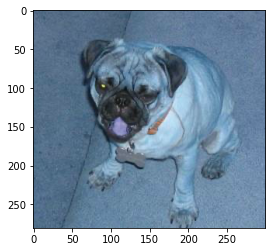

In [14]:
plt.imshow(im)

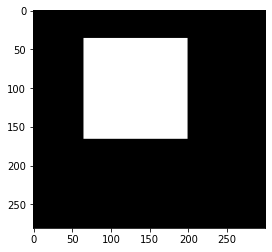

In [15]:
plt.imshow(Y, cmap='gray')

### Аугментация данных

Аугментация данных - это метод, позволяющий лучше обобщить нашу модель путем создания новых обучающих изображений с использованием различных вариантов существующих изображений. В нашем текущем обучающем наборе всего 800 изображений, поэтому увеличение данных очень важно, чтобы наша модель не переобучилась.  
Для этой задачи будем использовать переворот, поворот, центральную обрезку и случайную обрезку.

Единственное, что здесь нужно помнить, - это убедиться, что ограничивающая рамка также трансформируется так же, как и изображение. Для этого мы следуем тому же подходу, что и изменение размера - преобразуем ограничивающую рамку в маску, применяем те же преобразования к маске, что и исходное изображение, и извлекаем координаты ограничивающей рамки.

In [16]:
# Вырезаем кусок с изображения
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# Случайное вырезание части картинки
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

# Центральное вырезание 
def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

In [17]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Поворачиваем наше изображение"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Возвращает случайное вырезание"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

# Трансформируем нашу картинку 
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [18]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

### Пример изображения 

Оригинал:

dogs_cats\images_resized\Cats_Test1005.png


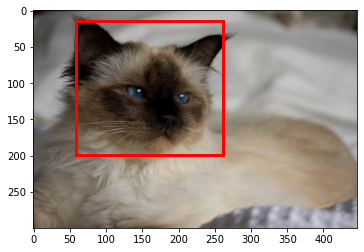

In [19]:
number = 9
im = cv2.imread(str(df_train.values[number][8]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[number][9])

После трансформации:

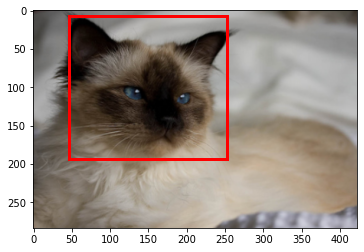

In [20]:
im, bb = transformsXY(str(df_train.values[number][8]),df_train.values[number][9],True )
show_corner_bb(im, bb)

### Датасет

Теперь, когда у нас есть дополнения к данным, мы можем создать набор данных PyTorch. Мы нормализуем изображения с помощью статистики ImageNet, потому что мы будем использовать предварительно обученную модель ResNet и применим аугментацию данных в нашем наборе данных во время обучения.

In [21]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
def normalize(im):
    """Нормализация данных с помощью статистики ImageNet"""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [23]:
class DCDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [24]:
train_ds = DCDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = DCDataset(X_val['new_path'],X_val['new_bb'],y_val)

Загрузим все это в наш даталоадер:

In [25]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

### Определение модели

В качестве модели мы будем использовать очень простую предварительно обученную модель [resNet-34](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet34). Поскольку здесь у нас есть две задачи, есть два последних слоя - регрессия ограничивающей рамки и классификатор изображений.

In [26]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 2))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

### Обучение

Для расчета потерь нам нужно принять во внимание как потерю классификации, так и потерю регрессии ограничивающего прямоугольника, поэтому мы используем комбинацию перекрестной энтропии и L1-потери (сумма всех абсолютных различий между истинным значением и прогнозируемыми координатами). Я масштабировал потери L1 в 1000 раз, потому что потери классификации и регрессии находятся в одном и том же диапазоне. Помимо этого, это стандартный цикл обучения PyTorch.

In [27]:
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)
epochs = 10


In [28]:
for i in trange(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        optimizer.zero_grad()
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
#         print(y_bb.shape)
#         print(y_class.shape)
        out_class, out_bb = model(x)
#         print(out_bb.shape)
#         print(out_class.shape)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")

        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

  0%|          | 0/10 [00:00<?, ?it/s]

train_loss 1.170 val_loss 1.152 val_acc 0.641
train_loss 0.913 val_loss 0.958 val_acc 0.653
train_loss 0.916 val_loss 0.861 val_acc 0.661
train_loss 0.831 val_loss 0.827 val_acc 0.642
train_loss 0.825 val_loss 0.857 val_acc 0.661
train_loss 0.814 val_loss 0.829 val_acc 0.660
train_loss 0.795 val_loss 0.927 val_acc 0.644
train_loss 0.786 val_loss 0.791 val_acc 0.664
train_loss 0.784 val_loss 0.790 val_acc 0.657
train_loss 0.774 val_loss 0.782 val_acc 0.661


Трюк: мы можешь после прохождения обучения изменить шаг обучения и продолжить:

In [59]:
for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = 0.003

In [60]:
epochs=5
for i in trange(epochs):
    
    model.train()
    total = 0
    sum_loss = 0
    C=1000
    
    for x, y_class, y_bb in train_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += batch
        sum_loss += loss.item()
    train_loss = sum_loss/total
    
    # Eval
    model.eval()
    val_total = 0
    val_sum_loss = 0
    correct = 0
    
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
#         print(out_bb.shape)
#         print(out_bb.shape)
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        val_sum_loss += loss.item()
        val_total += batch
    val_loss = val_sum_loss/val_total
    val_acc = correct/val_total
    
    print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))

  0%|          | 0/5 [00:00<?, ?it/s]

train_loss 0.715 val_loss 0.735 val_acc 0.702
train_loss 0.708 val_loss 0.818 val_acc 0.686
train_loss 0.685 val_loss 0.728 val_acc 0.711
train_loss 0.673 val_loss 0.699 val_acc 0.732
train_loss 0.664 val_loss 0.678 val_acc 0.729


# Тестирование

In [79]:
# resizing test image
image_number = 90
im = read_image(f'./dogs_cats/images_resized/cats_test{image_number}.png')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite(f'./dogs_cats/sample_signs_test/cats_test{image_number}.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [80]:
# test Dataset
test_ds = DCDataset(pd.DataFrame([{'path':f'./dogs_cats/sample_signs_test/cats_test{image_number}.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [81]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [82]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 0.7297, -0.6122]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 28.7039, 176.3724, 139.5629, 305.3147]], device='cuda:0',
        grad_fn=<AddmmBackward>))

In [83]:
# predicted class
torch.max(out_class, 1)

torch.return_types.max(
values=tensor([0.7297], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

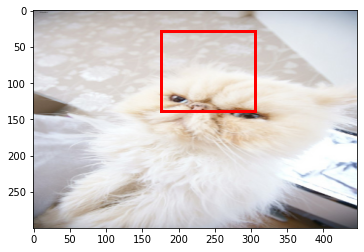

In [84]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

Ну лучше чем рандом это точно =)